In [1]:
#pip install pandas-profiling

In [2]:
#pip install -r ../requirements.txt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 80 kB 7.4 MB/s 
     |████████████████████████████████| 209 kB 33.6 MB/s 
     |████████████████████████████████| 75 kB 3.4 MB/s 
     |████████████████████████████████| 112 kB 28.3 MB/s 
     |████████████████████████████████| 149 kB 30.2 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=2f1213cec399f23bc5d1a1e47b19666eb14efc983564fc74ed7a46d6d4e86d70
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [7]:
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,StratifiedKFold
import matplotlib.pyplot as plt
import lightgbm as lgbm
import optuna
from sklearn.metrics import log_loss,f1_score

In [8]:
#from pandas_profiling import ProfileReport

#profile_train = ProfileReport(train, title="Pandas Profiling Report")
#profile_test = ProfileReport(test, title="Pandas Profiling Report")

#profile_train.to_file("train.html")
#profile_test.to_file("test.html")

In [9]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_job/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_job/data/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_job/data/sample_submission.csv')

In [10]:
for column in train.select_dtypes(include='bool').columns:
    train[column] = train[column].astype(int)
    
for column in test.select_dtypes(include='bool').columns:
    test[column] = test[column].astype(int)

In [11]:
train['contents_open_dt'] = pd.to_datetime(train['contents_open_dt'])
test['contents_open_dt'] = pd.to_datetime(test['contents_open_dt'])

train.sort_values(by='contents_open_dt',inplace=True)

In [12]:
for df in [train,test]:
    df['dia'] = pd.DatetimeIndex(df['contents_open_dt']).day
    df['hora'] = pd.DatetimeIndex(df['contents_open_dt']).hour
    df['dayofweek'] = df['contents_open_dt'].dt.dayofweek

In [13]:
for df in [train,test]:
    df.drop(['person_prefer_f',
             'person_prefer_g'
             #'h_m_match_yn',
             #'person_attribute_a'
             #'person_prefer_e',
             #'contents_attribute_c'
            ],axis=1,inplace=True)

In [14]:
#train = pd.get_dummies(train, columns=['person_attribute_a_1', 'person_attribute_b','person_prefer_c','person_prefer_e','contents_attribute_i','contents_attribute_j_1','contents_attribute_c','contents_attribute_m','contents_attribute_e'])
#test = pd.get_dummies(test, columns=['person_attribute_a_1', 'person_attribute_b','person_prefer_c','person_prefer_e','contents_attribute_i','contents_attribute_j_1','contents_attribute_c','contents_attribute_m','contents_attribute_e'])

#train = pd.get_dummies(train, columns=['contents_attribute_d'])
#test = pd.get_dummies(test, columns=['contents_attribute_d'])

In [15]:
y = train['target']
X = train.drop(['id','target','contents_open_dt'],axis = 1)
#X.columns = np.arange(X.shape[1])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

#X_train.columns = np.arange(X_train.shape[1])

cv_data = lgbm.Dataset(X, label = y)

train_ = train[pd.DatetimeIndex(train['contents_open_dt']).month != 11]
val = train[pd.DatetimeIndex(train['contents_open_dt']).month == 11]

y_train = train_['target']
X_train = train_.drop(['id','target','contents_open_dt'],axis = 1)

y_test = val['target']
X_test = val.drop(['id','target','contents_open_dt'],axis = 1)

In [16]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.95, step=0.1),
        "num_leaves": trial.suggest_int("num_leaves", 5, 100, step=5),
        "max_depth": trial.suggest_int("max_depth", 1, 30, step=3),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 1000, step=50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1, 30, step=3),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.99, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq",[1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.99, step=0.1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000, step=10),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    #return np.mean(f1_scores)
    return np.mean(cv_scores)

In [17]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2021-12-18 04:32:03,507] A new study created in memory with name: LGBM Classifier
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].



[1]	valid_0's binary_logloss: 0.715721	valid_0's binary_logloss: 0.715721
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.715671	valid_0's binary_logloss: 0.715671
[3]	valid_0's binary_logloss: 0.715671	valid_0's binary_logloss: 0.715671
[4]	valid_0's binary_logloss: 0.719838	valid_0's binary_logloss: 0.719838
[5]	valid_0's binary_logloss: 0.719838	valid_0's binary_logloss: 0.719838
[6]	valid_0's binary_logloss: 0.72479	valid_0's binary_logloss: 0.72479
[7]	valid_0's binary_logloss: 0.725447	valid_0's binary_logloss: 0.725447
[8]	valid_0's binary_logloss: 0.73161	valid_0's binary_logloss: 0.73161
[9]	valid_0's binary_logloss: 0.738569	valid_0's binary_logloss: 0.738569
[10]	valid_0's binary_logloss: 0.738569	valid_0's binary_logloss: 0.738569
[11]	valid_0's binary_logloss: 0.738569	valid_0's binary_logloss: 0.738569
[12]	valid_0's binary_logloss: 0.739459	valid_0's binary_logloss: 0.739459
[13]	valid_0's binary_logloss: 0.739347	valid_0's 

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.7093	valid_0's binary_logloss: 0.7093
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.710362	valid_0's binary_logloss: 0.710362
[3]	valid_0's binary_logloss: 0.710234	valid_0's binary_logloss: 0.710234
[4]	valid_0's binary_logloss: 0.702055	valid_0's binary_logloss: 0.702055


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.



[5]	valid_0's binary_logloss: 0.702055	valid_0's binary_logloss: 0.702055
[6]	valid_0's binary_logloss: 0.697117	valid_0's binary_logloss: 0.697117
[7]	valid_0's binary_logloss: 0.697117	valid_0's binary_logloss: 0.697117
[8]	valid_0's binary_logloss: 0.694476	valid_0's binary_logloss: 0.694476

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.




[9]	valid_0's binary_logloss: 0.691346	valid_0's binary_logloss: 0.691346
[10]	valid_0's binary_logloss: 0.691346	valid_0's binary_logloss: 0.691346
[11]	valid_0's binary_logloss: 0.690343	valid_0's binary_logloss: 0.690343
[12]	valid_0's binary_logloss: 0.690676	valid_0's binary_logloss: 0.690676
[13]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[14]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[15]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[16]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[17]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[18]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[19]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.



[20]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[21]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[22]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[23]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[24]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[25]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[26]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[27]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[28]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[29]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
[30]	valid_0's binary_logloss: 0.690995	valid_0's binary_logloss: 0.690995
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.690343	valid_0's binary_logloss: 0.690343


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.710084	valid_0's binary_logloss: 0.710084
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.711141	valid_0's binary_logloss: 0.711141
[3]	valid_0's binary_logloss: 0.711099	valid_0's binary_logloss: 0.711099
[4]	valid_0's binary_logloss: 0.703595	valid_0's binary_logloss: 0.703595


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.



[5]	valid_0's binary_logloss: 0.703595	valid_0's binary_logloss: 0.703595
[6]	valid_0's binary_logloss: 0.698391	valid_0's binary_logloss: 0.698391
[7]	valid_0's binary_logloss: 0.698391	valid_0's binary_logloss: 0.698391
[8]	valid_0's binary_logloss: 0.699258	valid_0's binary_logloss: 0.699258


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.



[9]	valid_0's binary_logloss: 0.695599	valid_0's binary_logloss: 0.695599
[10]	valid_0's binary_logloss: 0.696247	valid_0's binary_logloss: 0.696247
[11]	valid_0's binary_logloss: 0.693565	valid_0's binary_logloss: 0.693565
[12]	valid_0's binary_logloss: 0.69133	valid_0's binary_logloss: 0.69133


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.



[13]	valid_0's binary_logloss: 0.692153	valid_0's binary_logloss: 0.692153
[14]	valid_0's binary_logloss: 0.692153	valid_0's binary_logloss: 0.692153
[15]	valid_0's binary_logloss: 0.691971	valid_0's binary_logloss: 0.691971
[16]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[17]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[18]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.



[19]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[20]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[21]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[22]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[23]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.



[24]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[25]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[26]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[27]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[28]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
[29]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[30]	valid_0's binary_logloss: 0.691507	valid_0's binary_logloss: 0.691507
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.69133	valid_0's binary_logloss: 0.69133


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.709566	valid_0's binary_logloss: 0.709566
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.710699	valid_0's binary_logloss: 0.710699
[3]	valid_0's binary_logloss: 0.710589	valid_0's binary_logloss: 0.710589
[4]	valid_0's binary_logloss: 0.733848	valid_0's binary_logloss: 0.733848


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.



[5]	valid_0's binary_logloss: 0.734609	valid_0's binary_logloss: 0.734609
[6]	valid_0's binary_logloss: 0.744813	valid_0's binary_logloss: 0.744813
[7]	valid_0's binary_logloss: 0.744813	valid_0's binary_logloss: 0.744813
[8]	valid_0's binary_logloss: 0.749976	valid_0's binary_logloss: 0.749976


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.



[9]	valid_0's binary_logloss: 0.768214	valid_0's binary_logloss: 0.768214
[10]	valid_0's binary_logloss: 0.768923	valid_0's binary_logloss: 0.768923
[11]	valid_0's binary_logloss: 0.777786	valid_0's binary_logloss: 0.777786
[12]	valid_0's binary_logloss: 0.787328	valid_0's binary_logloss: 0.787328


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.



[13]	valid_0's binary_logloss: 0.788969	valid_0's binary_logloss: 0.788969
[14]	valid_0's binary_logloss: 0.788969	valid_0's binary_logloss: 0.788969
[15]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[16]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[17]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.



[18]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[19]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[20]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[21]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[22]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[23]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.



[24]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[25]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[26]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[27]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[28]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
[29]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[30]	valid_0's binary_logloss: 0.798545	valid_0's binary_logloss: 0.798545
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.709566	valid_0's binary_logloss: 0.709566


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.



[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[3]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[4]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[5]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[6]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.



[7]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[8]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[9]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[10]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[11]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[12]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.



[13]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[14]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[15]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[16]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[17]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[18]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.



[19]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[20]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[21]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[22]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[23]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[24]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[25]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[26]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[27]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[28]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[29]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[30]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


[I 2021-12-18 04:32:18,049] Trial 0 finished with value: 0.7573073213639442 and parameters: {'learning_rate': 0.5, 'num_leaves': 35, 'max_depth': 22, 'min_data_in_leaf': 550, 'lambda_l1': 60, 'lambda_l2': 100, 'min_gain_to_split': 16.0, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.5, 'n_estimators': 30}. Best is trial 0 with value: 0.7573073213639442.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0

[1]	valid_0's binary_logloss: 0.711165	valid_0's binary_logloss: 0.711165
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.718767	valid_0's binary_logloss: 0.718767
[3]	valid_0's binary_logloss: 0.719101	valid_0's binary_logloss: 0.719101
[4]	valid_0's binary_logloss: 0.720601	valid_0's binary_logloss: 0.720601
[5]	valid_0's binary_logloss: 0.726052	valid_0's binary_logloss: 0.726052
[6]	valid_0's binary_logloss: 0.726288	valid_0's binary_logloss: 0.726288
[7]	valid_0's binary_logloss: 0.726721	valid_0's binary_logloss: 0.726721
[8]	valid_0's binary_logloss: 0.726721	valid_0's binary_logloss: 0.726721
[9]	valid_0's binary_logloss: 0.728925	valid_0's binary_logloss: 0.728925
[10]	valid_0's binary_logloss: 0.731615	valid_0's binary_logloss: 0.731615
[11]	valid_0's binary_logloss: 0.732527	valid_0's binary_logloss: 0.732527
[12]	valid_0's binary_logloss: 0.733836	valid_0's binary_logloss: 0.733836
[13]	valid_0's binary_logloss: 0.739619	valid_

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.712178	valid_0's binary_logloss: 0.712178
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.708251	valid_0's binary_logloss: 0.708251
[3]	valid_0's binary_logloss: 0.70795	valid_0's binary_logloss: 0.70795
[4]	valid_0's binary_logloss: 0.706528	valid_0's binary_logloss: 0.706528


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[5]	valid_0's binary_logloss: 0.704898	valid_0's binary_logloss: 0.704898
[6]	valid_0's binary_logloss: 0.705054	valid_0's binary_logloss: 0.705054
[7]	valid_0's binary_logloss: 0.705219	valid_0's binary_logloss: 0.705219
[8]	valid_0's binary_logloss: 0.705219	valid_0's binary_logloss: 0.705219
[9]	valid_0's binary_logloss: 0.704605	valid_0's binary_logloss: 0.704605


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.



[10]	valid_0's binary_logloss: 0.701996	valid_0's binary_logloss: 0.701996
[11]	valid_0's binary_logloss: 0.702808	valid_0's binary_logloss: 0.702808
[12]	valid_0's binary_logloss: 0.702959	valid_0's binary_logloss: 0.702959
[13]	valid_0's binary_logloss: 0.699653	valid_0's binary_logloss: 0.699653
[14]	valid_0's binary_logloss: 0.698442	valid_0's binary_logloss: 0.698442


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[15]	valid_0's binary_logloss: 0.698837	valid_0's binary_logloss: 0.698837
[16]	valid_0's binary_logloss: 0.698837	valid_0's binary_logloss: 0.698837
[17]	valid_0's binary_logloss: 0.698837	valid_0's binary_logloss: 0.698837
[18]	valid_0's binary_logloss: 0.699116	valid_0's binary_logloss: 0.699116
[19]	valid_0's binary_logloss: 0.699637	valid_0's binary_logloss: 0.699637


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.



[20]	valid_0's binary_logloss: 0.699637	valid_0's binary_logloss: 0.699637
[21]	valid_0's binary_logloss: 0.696025	valid_0's binary_logloss: 0.696025
[22]	valid_0's binary_logloss: 0.69675	valid_0's binary_logloss: 0.69675
[23]	valid_0's binary_logloss: 0.69675	valid_0's binary_logloss: 0.69675
[24]	valid_0's binary_logloss: 0.696867	valid_0's binary_logloss: 0.696867

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.




[25]	valid_0's binary_logloss: 0.696722	valid_0's binary_logloss: 0.696722
[26]	valid_0's binary_logloss: 0.696722	valid_0's binary_logloss: 0.696722
[27]	valid_0's binary_logloss: 0.695595	valid_0's binary_logloss: 0.695595
[28]	valid_0's binary_logloss: 0.696285	valid_0's binary_logloss: 0.696285
[29]	valid_0's binary_logloss: 0.695675	valid_0's binary_logloss: 0.695675


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.



[30]	valid_0's binary_logloss: 0.695675	valid_0's binary_logloss: 0.695675
[31]	valid_0's binary_logloss: 0.695134	valid_0's binary_logloss: 0.695134
[32]	valid_0's binary_logloss: 0.693316	valid_0's binary_logloss: 0.693316
[33]	valid_0's binary_logloss: 0.693895	valid_0's binary_logloss: 0.693895


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.



[34]	valid_0's binary_logloss: 0.693551	valid_0's binary_logloss: 0.693551
[35]	valid_0's binary_logloss: 0.693613	valid_0's binary_logloss: 0.693613
[36]	valid_0's binary_logloss: 0.692698	valid_0's binary_logloss: 0.692698
[37]	valid_0's binary_logloss: 0.692698	valid_0's binary_logloss: 0.692698
[38]	valid_0's binary_logloss: 0.692698	valid_0's binary_logloss: 0.692698


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.



[39]	valid_0's binary_logloss: 0.692698	valid_0's binary_logloss: 0.692698
[40]	valid_0's binary_logloss: 0.692698	valid_0's binary_logloss: 0.692698
[41]	valid_0's binary_logloss: 0.69148	valid_0's binary_logloss: 0.69148
[42]	valid_0's binary_logloss: 0.69148	valid_0's binary_logloss: 0.69148
[43]	valid_0's binary_logloss: 0.69148	valid_0's binary_logloss: 0.69148


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.



[44]	valid_0's binary_logloss: 0.691235	valid_0's binary_logloss: 0.691235
[45]	valid_0's binary_logloss: 0.689555	valid_0's binary_logloss: 0.689555
[46]	valid_0's binary_logloss: 0.689916	valid_0's binary_logloss: 0.689916
[47]	valid_0's binary_logloss: 0.689664	valid_0's binary_logloss: 0.689664


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.



[48]	valid_0's binary_logloss: 0.688088	valid_0's binary_logloss: 0.688088
[49]	valid_0's binary_logloss: 0.68792	valid_0's binary_logloss: 0.68792
[50]	valid_0's binary_logloss: 0.6862	valid_0's binary_logloss: 0.6862
[51]	valid_0's binary_logloss: 0.686747	valid_0's binary_logloss: 0.686747


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.



[52]	valid_0's binary_logloss: 0.685239	valid_0's binary_logloss: 0.685239
[53]	valid_0's binary_logloss: 0.685275	valid_0's binary_logloss: 0.685275
[54]	valid_0's binary_logloss: 0.685275	valid_0's binary_logloss: 0.685275
[55]	valid_0's binary_logloss: 0.685275	valid_0's binary_logloss: 0.685275
[56]	valid_0's binary_logloss: 0.685275	valid_0's binary_logloss: 0.685275


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.



[57]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[58]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[59]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[60]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[61]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.



[62]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[63]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[64]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[65]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[66]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[67]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.



[68]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[69]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[70]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[71]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[72]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[73]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.



[74]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[75]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[76]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[77]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[78]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[79]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.



[80]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[81]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[82]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[83]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[84]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[85]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.



[86]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[87]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[88]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[89]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[90]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[91]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.



[92]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[93]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[94]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[95]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[96]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[97]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[98]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[99]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[100]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[101]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[102]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[103]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[104]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[105]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[106]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[107]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[108]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[109]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[110]	valid_0's binary_logloss: 0.685387	valid_0's binary_logloss: 0.685387
[111]	valid_0'

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.712593	valid_0's binary_logloss: 0.712593
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.709654	valid_0's binary_logloss: 0.709654
[3]	valid_0's binary_logloss: 0.710136	valid_0's binary_logloss: 0.710136
[4]	valid_0's binary_logloss: 0.70558	valid_0's binary_logloss: 0.70558


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[5]	valid_0's binary_logloss: 0.705113	valid_0's binary_logloss: 0.705113
[6]	valid_0's binary_logloss: 0.705311	valid_0's binary_logloss: 0.705311
[7]	valid_0's binary_logloss: 0.705769	valid_0's binary_logloss: 0.705769
[8]	valid_0's binary_logloss: 0.705769	valid_0's binary_logloss: 0.705769
[9]	valid_0's binary_logloss: 0.707293	valid_0's binary_logloss: 0.707293


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.



[10]	valid_0's binary_logloss: 0.704326	valid_0's binary_logloss: 0.704326
[11]	valid_0's binary_logloss: 0.704902	valid_0's binary_logloss: 0.704902
[12]	valid_0's binary_logloss: 0.704902	valid_0's binary_logloss: 0.704902
[13]	valid_0's binary_logloss: 0.702507	valid_0's binary_logloss: 0.702507
[14]	valid_0's binary_logloss: 0.700846	valid_0's binary_logloss: 0.700846


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[15]	valid_0's binary_logloss: 0.700836	valid_0's binary_logloss: 0.700836
[16]	valid_0's binary_logloss: 0.700836	valid_0's binary_logloss: 0.700836
[17]	valid_0's binary_logloss: 0.700871	valid_0's binary_logloss: 0.700871
[18]	valid_0's binary_logloss: 0.700871	valid_0's binary_logloss: 0.700871
[19]	valid_0's binary_logloss: 0.700871	valid_0's binary_logloss: 0.700871


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.



[20]	valid_0's binary_logloss: 0.700871	valid_0's binary_logloss: 0.700871
[21]	valid_0's binary_logloss: 0.699236	valid_0's binary_logloss: 0.699236
[22]	valid_0's binary_logloss: 0.699236	valid_0's binary_logloss: 0.699236
[23]	valid_0's binary_logloss: 0.699236	valid_0's binary_logloss: 0.699236
[24]	valid_0's binary_logloss: 0.699852	valid_0's binary_logloss: 0.699852


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.



[25]	valid_0's binary_logloss: 0.699852	valid_0's binary_logloss: 0.699852
[26]	valid_0's binary_logloss: 0.699599	valid_0's binary_logloss: 0.699599
[27]	valid_0's binary_logloss: 0.699302	valid_0's binary_logloss: 0.699302
[28]	valid_0's binary_logloss: 0.699319	valid_0's binary_logloss: 0.699319
[29]	valid_0's binary_logloss: 0.699319	valid_0's binary_logloss: 0.699319


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.



[30]	valid_0's binary_logloss: 0.699319	valid_0's binary_logloss: 0.699319
[31]	valid_0's binary_logloss: 0.699319	valid_0's binary_logloss: 0.699319
[32]	valid_0's binary_logloss: 0.696898	valid_0's binary_logloss: 0.696898
[33]	valid_0's binary_logloss: 0.694726	valid_0's binary_logloss: 0.694726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.



[34]	valid_0's binary_logloss: 0.693652	valid_0's binary_logloss: 0.693652
[35]	valid_0's binary_logloss: 0.693652	valid_0's binary_logloss: 0.693652
[36]	valid_0's binary_logloss: 0.69229	valid_0's binary_logloss: 0.69229
[37]	valid_0's binary_logloss: 0.69284	valid_0's binary_logloss: 0.69284
[38]	valid_0's binary_logloss: 0.69284	valid_0's binary_logloss: 0.69284


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.



[39]	valid_0's binary_logloss: 0.69284	valid_0's binary_logloss: 0.69284
[40]	valid_0's binary_logloss: 0.69284	valid_0's binary_logloss: 0.69284
[41]	valid_0's binary_logloss: 0.691852	valid_0's binary_logloss: 0.691852
[42]	valid_0's binary_logloss: 0.691852	valid_0's binary_logloss: 0.691852
[43]	valid_0's binary_logloss: 0.691961	valid_0's binary_logloss: 0.691961


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.



[44]	valid_0's binary_logloss: 0.691961	valid_0's binary_logloss: 0.691961
[45]	valid_0's binary_logloss: 0.691452	valid_0's binary_logloss: 0.691452
[46]	valid_0's binary_logloss: 0.691452	valid_0's binary_logloss: 0.691452
[47]	valid_0's binary_logloss: 0.69068	valid_0's binary_logloss: 0.69068


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.



[48]	valid_0's binary_logloss: 0.690264	valid_0's binary_logloss: 0.690264
[49]	valid_0's binary_logloss: 0.690264	valid_0's binary_logloss: 0.690264
[50]	valid_0's binary_logloss: 0.689763	valid_0's binary_logloss: 0.689763
[51]	valid_0's binary_logloss: 0.689763	valid_0's binary_logloss: 0.689763


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.



[52]	valid_0's binary_logloss: 0.689172	valid_0's binary_logloss: 0.689172
[53]	valid_0's binary_logloss: 0.689151	valid_0's binary_logloss: 0.689151
[54]	valid_0's binary_logloss: 0.689151	valid_0's binary_logloss: 0.689151
[55]	valid_0's binary_logloss: 0.689151	valid_0's binary_logloss: 0.689151
[56]	valid_0's binary_logloss: 0.689151	valid_0's binary_logloss: 0.689151


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.



[57]	valid_0's binary_logloss: 0.688312	valid_0's binary_logloss: 0.688312
[58]	valid_0's binary_logloss: 0.688312	valid_0's binary_logloss: 0.688312
[59]	valid_0's binary_logloss: 0.688258	valid_0's binary_logloss: 0.688258
[60]	valid_0's binary_logloss: 0.687763	valid_0's binary_logloss: 0.687763


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.



[61]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[62]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[63]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[64]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[65]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[66]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.



[67]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[68]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[69]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[70]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[71]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[72]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.



[73]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[74]	valid_0's binary_logloss: 0.687115	valid_0's binary_logloss: 0.687115
[75]	valid_0's binary_logloss: 0.686585	valid_0's binary_logloss: 0.686585
[76]	valid_0's binary_logloss: 0.686903	valid_0's binary_logloss: 0.686903
[77]	valid_0's binary_logloss: 0.686935	valid_0's binary_logloss: 0.686935


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.



[78]	valid_0's binary_logloss: 0.686732	valid_0's binary_logloss: 0.686732
[79]	valid_0's binary_logloss: 0.686732	valid_0's binary_logloss: 0.686732
[80]	valid_0's binary_logloss: 0.686815	valid_0's binary_logloss: 0.686815
[81]	valid_0's binary_logloss: 0.686815	valid_0's binary_logloss: 0.686815
[82]	valid_0's binary_logloss: 0.686815	valid_0's binary_logloss: 0.686815


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.



[83]	valid_0's binary_logloss: 0.686815	valid_0's binary_logloss: 0.686815
[84]	valid_0's binary_logloss: 0.686771	valid_0's binary_logloss: 0.686771
[85]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[86]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.



[87]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[88]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[89]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[90]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[91]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[92]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.



[93]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[94]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[95]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[96]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679
[97]	valid_0's binary_logloss: 0.686679	valid_0's binary_logloss: 0.686679


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 101 is already reported.



[98]	valid_0's binary_logloss: 0.68679	valid_0's binary_logloss: 0.68679
[99]	valid_0's binary_logloss: 0.68679	valid_0's binary_logloss: 0.68679
[100]	valid_0's binary_logloss: 0.68679	valid_0's binary_logloss: 0.68679
[101]	valid_0's binary_logloss: 0.68679	valid_0's binary_logloss: 0.68679
[102]	valid_0's binary_logloss: 0.686305	valid_0's binary_logloss: 0.686305


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 102 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 103 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 104 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 105 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 106 is already reported.



[103]	valid_0's binary_logloss: 0.686236	valid_0's binary_logloss: 0.686236
[104]	valid_0's binary_logloss: 0.686236	valid_0's binary_logloss: 0.686236
[105]	valid_0's binary_logloss: 0.686236	valid_0's binary_logloss: 0.686236
[106]	valid_0's binary_logloss: 0.686236	valid_0's binary_logloss: 0.686236
[107]	valid_0's binary_logloss: 0.686236	valid_0's binary_logloss: 0.686236


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 107 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 108 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 109 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 110 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 111 is already reported.



[108]	valid_0's binary_logloss: 0.686236	valid_0's binary_logloss: 0.686236
[109]	valid_0's binary_logloss: 0.686236	valid_0's binary_logloss: 0.686236
[110]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[111]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[112]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 112 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 113 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 114 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 115 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 116 is already reported.



[113]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[114]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[115]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[116]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[117]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 117 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 118 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 119 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 120 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 121 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 122 is already reported.



[118]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[119]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[120]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[121]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[122]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[123]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 123 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 124 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 125 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 126 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 127 is already reported.



[124]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[125]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[126]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[127]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[128]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 128 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 129 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 130 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 131 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 132 is already reported.



[129]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[130]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[131]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[132]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[133]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 133 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 134 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 135 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 136 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 137 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 138 is already reported.



[134]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[135]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[136]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[137]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[138]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[139]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 139 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 140 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 141 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 142 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 143 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 144 is already reported.



[140]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[141]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[142]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[143]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[144]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[145]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 145 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 146 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 147 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 148 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 149 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 150 is already reported.



[146]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[147]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[148]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[149]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[150]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[151]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 151 is already reported.



[152]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[153]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[154]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[155]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[156]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[157]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[158]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[159]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[160]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[161]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[162]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[163]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[164]	valid_0's binary_logloss: 0.686182	valid_0's binary_logloss: 0.686182
[165]	valid_

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.709439	valid_0's binary_logloss: 0.709439
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.715041	valid_0's binary_logloss: 0.715041
[3]	valid_0's binary_logloss: 0.714944	valid_0's binary_logloss: 0.714944
[4]	valid_0's binary_logloss: 0.719887	valid_0's binary_logloss: 0.719887


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.



[5]	valid_0's binary_logloss: 0.734186	valid_0's binary_logloss: 0.734186
[6]	valid_0's binary_logloss: 0.734603	valid_0's binary_logloss: 0.734603
[7]	valid_0's binary_logloss: 0.734717	valid_0's binary_logloss: 0.734717
[8]	valid_0's binary_logloss: 0.734717	valid_0's binary_logloss: 0.734717


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.



[9]	valid_0's binary_logloss: 0.744671	valid_0's binary_logloss: 0.744671
[10]	valid_0's binary_logloss: 0.769464	valid_0's binary_logloss: 0.769464
[11]	valid_0's binary_logloss: 0.771215	valid_0's binary_logloss: 0.771215
[12]	valid_0's binary_logloss: 0.771533	valid_0's binary_logloss: 0.771533


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.



[13]	valid_0's binary_logloss: 0.776831	valid_0's binary_logloss: 0.776831
[14]	valid_0's binary_logloss: 0.781773	valid_0's binary_logloss: 0.781773
[15]	valid_0's binary_logloss: 0.782802	valid_0's binary_logloss: 0.782802
[16]	valid_0's binary_logloss: 0.783218	valid_0's binary_logloss: 0.783218


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.



[17]	valid_0's binary_logloss: 0.783609	valid_0's binary_logloss: 0.783609
[18]	valid_0's binary_logloss: 0.783251	valid_0's binary_logloss: 0.783251
[19]	valid_0's binary_logloss: 0.783251	valid_0's binary_logloss: 0.783251
[20]	valid_0's binary_logloss: 0.783251	valid_0's binary_logloss: 0.783251
[21]	valid_0's binary_logloss: 0.804766	valid_0's binary_logloss: 0.804766


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.



[22]	valid_0's binary_logloss: 0.805124	valid_0's binary_logloss: 0.805124
[23]	valid_0's binary_logloss: 0.805124	valid_0's binary_logloss: 0.805124
[24]	valid_0's binary_logloss: 0.805138	valid_0's binary_logloss: 0.805138
[25]	valid_0's binary_logloss: 0.805138	valid_0's binary_logloss: 0.805138
[26]	valid_0's binary_logloss: 0.806068	valid_0's binary_logloss: 0.806068


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.



[27]	valid_0's binary_logloss: 0.80888	valid_0's binary_logloss: 0.80888
[28]	valid_0's binary_logloss: 0.80759	valid_0's binary_logloss: 0.80759
[29]	valid_0's binary_logloss: 0.808487	valid_0's binary_logloss: 0.808487
[30]	valid_0's binary_logloss: 0.808487	valid_0's binary_logloss: 0.808487
[31]	valid_0's binary_logloss: 0.808487	valid_0's binary_logloss: 0.808487


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.



[32]	valid_0's binary_logloss: 0.810356	valid_0's binary_logloss: 0.810356
[33]	valid_0's binary_logloss: 0.820304	valid_0's binary_logloss: 0.820304
[34]	valid_0's binary_logloss: 0.828526	valid_0's binary_logloss: 0.828526
[35]	valid_0's binary_logloss: 0.828526	valid_0's binary_logloss: 0.828526


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[36]	valid_0's binary_logloss: 0.836217	valid_0's binary_logloss: 0.836217
[37]	valid_0's binary_logloss: 0.836104	valid_0's binary_logloss: 0.836104
[38]	valid_0's binary_logloss: 0.837591	valid_0's binary_logloss: 0.837591
[39]	valid_0's binary_logloss: 0.837591	valid_0's binary_logloss: 0.837591
[40]	valid_0's binary_logloss: 0.837116	valid_0's binary_logloss: 0.837116


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.



[41]	valid_0's binary_logloss: 0.844123	valid_0's binary_logloss: 0.844123
[42]	valid_0's binary_logloss: 0.844123	valid_0's binary_logloss: 0.844123
[43]	valid_0's binary_logloss: 0.844123	valid_0's binary_logloss: 0.844123
[44]	valid_0's binary_logloss: 0.843961	valid_0's binary_logloss: 0.843961
[45]	valid_0's binary_logloss: 0.843262	valid_0's binary_logloss: 0.843262


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.



[46]	valid_0's binary_logloss: 0.844488	valid_0's binary_logloss: 0.844488
[47]	valid_0's binary_logloss: 0.847973	valid_0's binary_logloss: 0.847973
[48]	valid_0's binary_logloss: 0.850978	valid_0's binary_logloss: 0.850978
[49]	valid_0's binary_logloss: 0.850978	valid_0's binary_logloss: 0.850978


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.



[50]	valid_0's binary_logloss: 0.852254	valid_0's binary_logloss: 0.852254
[51]	valid_0's binary_logloss: 0.852254	valid_0's binary_logloss: 0.852254
[52]	valid_0's binary_logloss: 0.857302	valid_0's binary_logloss: 0.857302
[53]	valid_0's binary_logloss: 0.861711	valid_0's binary_logloss: 0.861711
[54]	valid_0's binary_logloss: 0.861711	valid_0's binary_logloss: 0.861711


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.



[55]	valid_0's binary_logloss: 0.861711	valid_0's binary_logloss: 0.861711
[56]	valid_0's binary_logloss: 0.861711	valid_0's binary_logloss: 0.861711
[57]	valid_0's binary_logloss: 0.867003	valid_0's binary_logloss: 0.867003
[58]	valid_0's binary_logloss: 0.866599	valid_0's binary_logloss: 0.866599
[59]	valid_0's binary_logloss: 0.87076	valid_0's binary_logloss: 0.87076


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.



[60]	valid_0's binary_logloss: 0.870343	valid_0's binary_logloss: 0.870343
[61]	valid_0's binary_logloss: 0.870343	valid_0's binary_logloss: 0.870343
[62]	valid_0's binary_logloss: 0.870343	valid_0's binary_logloss: 0.870343
[63]	valid_0's binary_logloss: 0.870343	valid_0's binary_logloss: 0.870343
[64]	valid_0's binary_logloss: 0.871409	valid_0's binary_logloss: 0.871409
[65]	valid_0's binary_logloss: 0.871409	valid_0's binary_logloss: 0.871409


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.



[66]	valid_0's binary_logloss: 0.871409	valid_0's binary_logloss: 0.871409
[67]	valid_0's binary_logloss: 0.871409	valid_0's binary_logloss: 0.871409
[68]	valid_0's binary_logloss: 0.871352	valid_0's binary_logloss: 0.871352
[69]	valid_0's binary_logloss: 0.871352	valid_0's binary_logloss: 0.871352
[70]	valid_0's binary_logloss: 0.871352	valid_0's binary_logloss: 0.871352


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.



[71]	valid_0's binary_logloss: 0.871352	valid_0's binary_logloss: 0.871352
[72]	valid_0's binary_logloss: 0.871352	valid_0's binary_logloss: 0.871352
[73]	valid_0's binary_logloss: 0.871352	valid_0's binary_logloss: 0.871352
[74]	valid_0's binary_logloss: 0.871352	valid_0's binary_logloss: 0.871352
[75]	valid_0's binary_logloss: 0.873349	valid_0's binary_logloss: 0.873349


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.



[76]	valid_0's binary_logloss: 0.873349	valid_0's binary_logloss: 0.873349
[77]	valid_0's binary_logloss: 0.875792	valid_0's binary_logloss: 0.875792
[78]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[79]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[80]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[81]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.



[82]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[83]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[84]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[85]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[86]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[87]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.



[88]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[89]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[90]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[91]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[92]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.



[93]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[94]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[95]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[96]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[97]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[98]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[99]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[100]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
[101]	valid_0's binary_logloss: 0.874809	valid_0's binary_logloss: 0.874809
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.709439	valid_0's binary_logloss: 0.709439


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.



[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[3]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[4]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[5]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[6]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.



[7]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[8]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[9]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[10]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[11]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[12]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.



[13]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[14]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[15]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[16]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[17]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[18]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.



[19]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[20]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[21]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[22]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[23]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[24]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[25]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[26]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[27]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[28]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[29]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[30]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.



[31]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[32]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[33]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[34]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[35]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[36]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.



[37]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[38]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[39]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[40]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[41]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[42]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.



[43]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[44]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[45]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[46]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[47]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[48]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.



[49]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[50]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[51]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[52]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[53]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[54]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.



[55]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[56]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[57]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[58]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[59]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[60]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.



[61]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[62]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[63]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[64]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[65]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[66]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.



[67]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[68]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[69]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[70]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[71]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[72]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.



[73]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[74]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[75]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[76]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[77]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[78]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.



[79]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[80]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[81]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[82]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[83]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.



[84]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[85]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[86]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[87]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[88]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[89]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.



[90]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[91]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[92]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[93]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[94]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[95]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[96]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[97]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[98]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[99]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[100]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[101]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


[I 2021-12-18 04:32:55,219] Trial 1 finished with value: 0.7541014408605666 and parameters: {'learning_rate': 0.8, 'num_leaves': 10, 'max_depth': 25, 'min_data_in_leaf': 400, 'lambda_l1': 25, 'lambda_l2': 55, 'min_gain_to_split': 7.0, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2, 'n_estimators': 1220}. Best is trial 1 with value: 0.7541014408605666.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0

[1]	valid_0's binary_logloss: 0.720755	valid_0's binary_logloss: 0.720755
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.720968	valid_0's binary_logloss: 0.720968
[3]	valid_0's binary_logloss: 0.720967	valid_0's binary_logloss: 0.720967
[4]	valid_0's binary_logloss: 0.740368	valid_0's binary_logloss: 0.740368
[5]	valid_0's binary_logloss: 0.751233	valid_0's binary_logloss: 0.751233
[6]	valid_0's binary_logloss: 0.766798	valid_0's binary_logloss: 0.766798
[7]	valid_0's binary_logloss: 0.766798	valid_0's binary_logloss: 0.766798
[8]	valid_0's binary_logloss: 0.772679	valid_0's binary_logloss: 0.772679
[9]	valid_0's binary_logloss: 0.773319	valid_0's binary_logloss: 0.773319
[10]	valid_0's binary_logloss: 0.773319	valid_0's binary_logloss: 0.773319
[11]	valid_0's binary_logloss: 0.773319	valid_0's binary_logloss: 0.773319
[12]	valid_0's binary_logloss: 0.773319	valid_0's binary_logloss: 0.773319
[13]	valid_0's binary_logloss: 0.773319	valid_

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.705802	valid_0's binary_logloss: 0.705802
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.706852	valid_0's binary_logloss: 0.706852
[3]	valid_0's binary_logloss: 0.706927	valid_0's binary_logloss: 0.706927
[4]	valid_0's binary_logloss: 0.698255	valid_0's binary_logloss: 0.698255


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.



[5]	valid_0's binary_logloss: 0.689537	valid_0's binary_logloss: 0.689537
[6]	valid_0's binary_logloss: 0.688134	valid_0's binary_logloss: 0.688134
[7]	valid_0's binary_logloss: 0.688134	valid_0's binary_logloss: 0.688134


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.



[8]	valid_0's binary_logloss: 0.687089	valid_0's binary_logloss: 0.687089
[9]	valid_0's binary_logloss: 0.684345	valid_0's binary_logloss: 0.684345
[10]	valid_0's binary_logloss: 0.683162	valid_0's binary_logloss: 0.683162


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[11]	valid_0's binary_logloss: 0.683162	valid_0's binary_logloss: 0.683162
[12]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[13]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[14]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[15]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.



[16]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[17]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[18]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[19]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[20]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.



[21]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[22]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[23]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[24]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[25]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[26]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[27]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[28]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[29]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[30]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.



[31]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[32]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[33]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[34]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[35]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[36]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[37]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[38]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[39]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[40]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.



[41]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[42]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[43]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[44]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[45]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[46]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[47]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[48]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[49]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[50]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.



[51]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[52]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[53]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[54]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[55]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.



[56]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[57]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[58]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[59]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[60]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.



[61]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[62]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[63]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[64]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[65]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.



[66]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[67]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[68]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[69]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[70]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.



[71]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[72]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[73]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[74]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[75]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.



[76]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[77]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[78]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[79]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[80]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.



[81]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[82]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[83]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[84]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[85]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.



[86]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[87]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[88]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[89]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[90]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.



[91]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[92]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[93]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[94]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[95]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.



[96]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[97]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[98]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[99]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[100]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[101]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[102]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[103]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[104]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[105]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[106]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[107]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[108]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[109]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
[110]	valid_0's binary_logloss: 0.683274	valid_0's binary_logloss: 0.683274
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.683162	valid_0's binary_logloss: 0.683162


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.706837	valid_0's binary_logloss: 0.706837
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.708131	valid_0's binary_logloss: 0.708131
[3]	valid_0's binary_logloss: 0.708186	valid_0's binary_logloss: 0.708186
[4]	valid_0's binary_logloss: 0.697577	valid_0's binary_logloss: 0.697577


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.



[5]	valid_0's binary_logloss: 0.690447	valid_0's binary_logloss: 0.690447
[6]	valid_0's binary_logloss: 0.687646	valid_0's binary_logloss: 0.687646
[7]	valid_0's binary_logloss: 0.688089	valid_0's binary_logloss: 0.688089
[8]	valid_0's binary_logloss: 0.688307	valid_0's binary_logloss: 0.688307


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.



[9]	valid_0's binary_logloss: 0.687198	valid_0's binary_logloss: 0.687198
[10]	valid_0's binary_logloss: 0.687413	valid_0's binary_logloss: 0.687413
[11]	valid_0's binary_logloss: 0.687413	valid_0's binary_logloss: 0.687413
[12]	valid_0's binary_logloss: 0.687749	valid_0's binary_logloss: 0.687749
[13]	valid_0's binary_logloss: 0.687794	valid_0's binary_logloss: 0.687794


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.



[14]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[15]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[16]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[17]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[18]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.



[19]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[20]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[21]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[22]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[23]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.



[24]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[25]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[26]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[27]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[28]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.



[29]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[30]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[31]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[32]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[33]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.



[34]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[35]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[36]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[37]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[38]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.



[39]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[40]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[41]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[42]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[43]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.



[44]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[45]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[46]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[47]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[48]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.



[49]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[50]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[51]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[52]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[53]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.



[54]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[55]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[56]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[57]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[58]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.



[59]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[60]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[61]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[62]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[63]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.



[64]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[65]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[66]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[67]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[68]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.



[69]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[70]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[71]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[72]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[73]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.



[74]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[75]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[76]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[77]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[78]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.



[79]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[80]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[81]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[82]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[83]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.



[84]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[85]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[86]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[87]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[88]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.



[89]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[90]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[91]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[92]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[93]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.



[94]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[95]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[96]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[97]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[98]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 101 is already reported.



[99]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[100]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[101]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[102]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 102 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 103 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 104 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 105 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 106 is already reported.



[103]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[104]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[105]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[106]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[107]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 107 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 108 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 109 is already reported.



[108]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[109]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[110]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[111]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[112]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[113]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
[114]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.685081	valid_0's binary_logloss: 0.685081


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.72674	valid_0's binary_logloss: 0.72674
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.727476	valid_0's binary_logloss: 0.727476
[3]	valid_0's binary_logloss: 0.72746	valid_0's binary_logloss: 0.72746
[4]	valid_0's binary_logloss: 0.769454	valid_0's binary_logloss: 0.769454


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.



[5]	valid_0's binary_logloss: 0.791654	valid_0's binary_logloss: 0.791654
[6]	valid_0's binary_logloss: 0.805492	valid_0's binary_logloss: 0.805492
[7]	valid_0's binary_logloss: 0.805492	valid_0's binary_logloss: 0.805492


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.



[8]	valid_0's binary_logloss: 0.823864	valid_0's binary_logloss: 0.823864
[9]	valid_0's binary_logloss: 0.849393	valid_0's binary_logloss: 0.849393
[10]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[11]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.



[12]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[13]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[14]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[15]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[16]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.



[17]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[18]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[19]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[20]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[21]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.



[22]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[23]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[24]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[25]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[26]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.



[27]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[28]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[29]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[30]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[31]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.



[32]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[33]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[34]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.



[35]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[36]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.



[37]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[38]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.



[39]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[40]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[41]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[42]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[43]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.



[44]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[45]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[46]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[47]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[48]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.



[49]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[50]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[51]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[52]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[53]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.



[54]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[55]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[56]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[57]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[58]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.



[59]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[60]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[61]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[62]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[63]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.



[64]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[65]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[66]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[67]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[68]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.



[69]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[70]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[71]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[72]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[73]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.



[74]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[75]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[76]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[77]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[78]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.



[79]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[80]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[81]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[82]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[83]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.



[84]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[85]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[86]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[87]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[88]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.



[89]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[90]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[91]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[92]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[93]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.



[94]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[95]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[96]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[97]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[98]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[99]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[100]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
[101]	valid_0's binary_logloss: 0.85372	valid_0's binary_logloss: 0.85372
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.72674	valid_0's binary_logloss: 0.72674


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.



[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[3]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[4]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[5]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.



[6]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[7]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[8]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[9]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[10]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[11]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[12]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[13]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[14]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[15]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.



[16]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[17]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[18]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[19]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[20]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.



[21]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[22]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[23]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[24]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[25]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[26]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[27]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[28]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[29]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[30]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.



[31]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[32]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[33]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[34]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[35]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[36]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[37]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[38]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[39]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[40]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.



[41]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[42]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[43]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[44]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[45]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[46]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[47]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[48]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[49]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[50]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.



[51]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[52]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[53]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[54]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[55]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.



[56]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[57]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[58]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[59]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[60]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.



[61]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[62]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[63]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[64]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[65]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.



[66]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[67]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[68]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[69]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[70]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.



[71]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[72]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[73]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[74]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[75]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.



[76]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[77]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[78]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[79]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[80]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.



[81]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[82]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[83]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[84]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[85]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.



[86]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[87]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[88]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[89]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[90]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.



[91]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[92]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[93]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[94]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[95]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.



[96]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[97]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[98]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[99]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[100]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

[I 2021-12-18 04:33:29,026] Trial 2 finished with value: 0.7588366407421537 and parameters: {'learning_rate': 0.5, 'num_leaves': 55, 'max_depth': 22, 'min_data_in_leaf': 650, 'lambda_l1': 30, 'lambda_l2': 5, 'min_gain_to_split': 16.0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6, 'n_estimators': 1390}. Best is trial 1 with value: 0.7541014408605666.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna

[101]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[1]	valid_0's binary_logloss: 0.712865	valid_0's binary_logloss: 0.712865
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.711785	valid_0's binary_logloss: 0.711785
[3]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[4]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[5]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[6]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[7]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[8]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[9]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[10]	valid_0's binary_logloss: 0.723495	valid_0's binary_logloss: 0.723495
[11]	valid_0's 

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.71227	valid_0's binary_logloss: 0.71227
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.700729	valid_0's binary_logloss: 0.700729
[3]	valid_0's binary_logloss: 0.701039	valid_0's binary_logloss: 0.701039
[4]	valid_0's binary_logloss: 0.701039	valid_0's binary_logloss: 0.701039


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.



[5]	valid_0's binary_logloss: 0.701039	valid_0's binary_logloss: 0.701039
[6]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[7]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[8]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[9]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[10]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.



[11]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[12]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[13]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[14]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[15]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[16]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.



[17]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[18]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[19]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[20]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[21]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[22]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.



[23]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[24]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[25]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[26]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[27]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[28]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.



[29]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[30]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[31]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[32]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[33]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[34]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[35]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[36]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[37]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[38]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[39]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[40]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.



[41]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[42]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[43]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[44]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[45]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[46]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.



[47]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[48]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[49]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[50]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[51]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[52]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.



[53]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[54]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[55]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[56]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[57]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[58]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.



[59]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[60]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[61]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[62]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[63]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[64]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.



[65]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[66]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[67]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[68]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[69]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[70]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.



[71]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[72]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[73]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[74]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[75]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[76]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.



[77]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[78]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[79]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[80]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[81]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[82]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.



[83]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[84]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[85]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[86]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[87]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.



[88]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[89]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[90]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[91]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[92]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[93]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.



[94]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[95]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[96]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[97]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[98]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[99]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 101 is already reported.



[100]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[101]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
[102]	valid_0's binary_logloss: 0.701185	valid_0's binary_logloss: 0.701185
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.700729	valid_0's binary_logloss: 0.700729


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.711991	valid_0's binary_logloss: 0.711991
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.706548	valid_0's binary_logloss: 0.706548
[3]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251
[4]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.



[5]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251
[6]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251
[7]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251
[8]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251
[9]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251
[10]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.



[11]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228
[12]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228
[13]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228
[14]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228
[15]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228
[16]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.



[17]	valid_0's binary_logloss: 0.70228	valid_0's binary_logloss: 0.70228
[18]	valid_0's binary_logloss: 0.701323	valid_0's binary_logloss: 0.701323
[19]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[20]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[21]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.



[22]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[23]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[24]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[25]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[26]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[27]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.



[28]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[29]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[30]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[31]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[32]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[33]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.



[34]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[35]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[36]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[37]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[38]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[39]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.



[40]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[41]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[42]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[43]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[44]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[45]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.



[46]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[47]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[48]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[49]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[50]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[51]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.



[52]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[53]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[54]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[55]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[56]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[57]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.



[58]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[59]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[60]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[61]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[62]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[63]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.



[64]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[65]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[66]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[67]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[68]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[69]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.



[70]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[71]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[72]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[73]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[74]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[75]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.



[76]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[77]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[78]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[79]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[80]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[81]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.



[82]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[83]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[84]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[85]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[86]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[87]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.



[88]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[89]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[90]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[91]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[92]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[93]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.



[94]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[95]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[96]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[97]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[98]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[99]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 101 is already reported.



[100]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[101]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[102]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
[103]	valid_0's binary_logloss: 0.701266	valid_0's binary_logloss: 0.701266
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.701251	valid_0's binary_logloss: 0.701251


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 0.707935	valid_0's binary_logloss: 0.707935
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.711093	valid_0's binary_logloss: 0.711093
[3]	valid_0's binary_logloss: 0.746707	valid_0's binary_logloss: 0.746707


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.



[4]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[5]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[6]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[7]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[8]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.



[9]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[10]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[11]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[12]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[13]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[14]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.



[15]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[16]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[17]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[18]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[19]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[20]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.



[21]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[22]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[23]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[24]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[25]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[26]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.



[27]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[28]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[29]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[30]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[31]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[32]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.



[33]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[34]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[35]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[36]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[37]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[38]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.



[39]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[40]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[41]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[42]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[43]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[44]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[45]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[46]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[47]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[48]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[49]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[50]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.



[51]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[52]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[53]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[54]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[55]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[56]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.



[57]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[58]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[59]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[60]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[61]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[62]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.



[63]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[64]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[65]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[66]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[67]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[68]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.



[69]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[70]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[71]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[72]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[73]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[74]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.



[75]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[76]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[77]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[78]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[79]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[80]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.



[81]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[82]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[83]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[84]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[85]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.



[86]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[87]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[88]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[89]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[90]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[91]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.



[92]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[93]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[94]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[95]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[96]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[97]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.



[98]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[99]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
[100]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[101]	valid_0's binary_logloss: 0.752613	valid_0's binary_logloss: 0.752613
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.707935	valid_0's binary_logloss: 0.707935


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[3]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.



[4]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[5]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.



[6]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[7]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[8]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[9]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.



[10]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[11]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.



[12]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[13]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[14]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[15]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.



[16]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[17]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[18]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[19]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.



[20]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[21]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.



[22]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[23]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.



[24]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[25]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[26]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.



[27]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[28]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[29]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[30]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.



[31]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[32]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.



[33]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[34]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.



[35]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[36]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.



[37]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[38]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.



[39]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[40]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.



[41]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[42]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.



[43]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[44]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.



[45]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[46]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.



[47]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[48]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.



[49]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[50]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.



[51]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[52]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.



[53]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[54]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.



[55]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[56]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.



[57]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[58]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.



[59]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[60]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.



[61]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[62]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.



[63]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[64]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[65]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.



[66]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[67]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[68]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.



[69]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[70]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.



[71]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[72]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[73]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.



[74]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[75]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[76]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.



[77]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[78]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[79]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.



[80]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[81]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[82]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.



[83]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[84]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.



[85]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[86]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.



[87]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[88]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.



[89]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[90]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.



[91]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[92]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.



[93]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[94]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.



[95]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[96]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[97]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.



[98]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[99]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[100]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

[I 2021-12-18 04:34:07,178] Trial 3 finished with value: 0.760006649885826 and parameters: {'learning_rate': 0.7000000000000001, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 800, 'lambda_l1': 70, 'lambda_l2': 15, 'min_gain_to_split': 25.0, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'n_estimators': 900}. Best is trial 1 with value: 0.7541014408605666.


[101]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].



[1]	valid_0's binary_logloss: 0.71199	valid_0's binary_logloss: 0.71199
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.710917	valid_0's binary_logloss: 0.710917
[3]	valid_0's binary_logloss: 0.710917	valid_0's binary_logloss: 0.710917
[4]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[5]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[6]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[7]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[8]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[9]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[10]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[11]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[12]	valid_0's binary_logloss: 0.713512	valid_0's binary_logloss: 0.713512
[13]	valid_0's binary_logloss: 0.713512	valid_0'

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: Use

[1]	valid_0's binary_logloss: 0.711438	valid_0's binary_logloss: 0.711438
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.711591	valid_0's binary_logloss: 0.711591
[3]	valid_0's binary_logloss: 0.711591	valid_0's binary_logloss: 0.711591
[4]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[5]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[6]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[7]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[8]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592:

[9]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[10]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[11]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[12]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[13]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[14]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[15]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[16]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[17]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[18]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[19]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[20]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[21]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[22]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[23]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[24]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[25]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[26]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[27]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[28]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[29]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[30]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.



[31]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[32]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[33]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[34]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[35]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[36]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[37]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[38]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[39]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[40]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[41]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[42]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[43]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[44]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[45]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[46]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[47]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[48]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[49]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[50]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[51]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[52]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[53]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[54]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[55]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[56]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[57]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[58]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[59]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[60]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[61]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[62]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[63]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[64]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[65]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[66]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[67]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[68]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[69]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[70]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[71]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[72]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[73]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[74]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[75]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[76]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[77]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[78]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[79]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[80]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[81]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[82]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[83]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[84]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[85]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[86]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[87]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[88]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[89]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[90]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[91]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[92]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.



[93]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[94]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[95]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[96]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[97]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[98]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[99]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[100]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
[101]	valid_0's binary_logloss: 0.712748	valid_0's binary_logloss: 0.712748
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.711438	valid_0's binary_logloss: 0.711438


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.



[1]	valid_0's binary_logloss: 0.711853	valid_0's binary_logloss: 0.711853
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.712067	valid_0's binary_logloss: 0.712067
[3]	valid_0's binary_logloss: 0.712067	valid_0's binary_logloss: 0.712067
[4]	valid_0's binary_logloss: 0.712837	valid_0's binary_logloss: 0.712837
[5]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[6]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: U

[7]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[8]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[9]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[10]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[11]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[12]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[13]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[14]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[15]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[16]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[17]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[18]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[19]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[20]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[21]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[22]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[23]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[24]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[25]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[26]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[27]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[28]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[29]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[30]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[31]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[32]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[33]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[34]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[35]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[36]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[37]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[38]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[39]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[40]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[41]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[42]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[43]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[44]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[45]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[46]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[47]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[48]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[49]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[50]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[51]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[52]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[53]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[54]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[55]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[56]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[57]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[58]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[59]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[60]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[61]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[62]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[63]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[64]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[65]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[66]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[67]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[68]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[69]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[70]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[71]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[72]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[73]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[74]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[75]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[76]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[77]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[78]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[79]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[80]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[81]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[82]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[83]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[84]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[85]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[86]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[87]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[88]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[89]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[90]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[91]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[92]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[93]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[94]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[95]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[96]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[97]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[98]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[99]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[100]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 101 is already reported.



[101]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[102]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[103]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[104]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
[105]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.711849	valid_0's binary_logloss: 0.711849


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: Use

[1]	valid_0's binary_logloss: 0.708629	valid_0's binary_logloss: 0.708629
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.708908	valid_0's binary_logloss: 0.708908
[3]	valid_0's binary_logloss: 0.708908	valid_0's binary_logloss: 0.708908
[4]	valid_0's binary_logloss: 0.709563	valid_0's binary_logloss: 0.709563
[5]	valid_0's binary_logloss: 0.709563	valid_0's binary_logloss: 0.709563
[6]	valid_0's binary_logloss: 0.709867	valid_0's binary_logloss: 0.709867
[7]	valid_0's binary_logloss: 0.710352	valid_0's binary_logloss: 0.710352


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: 

[8]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[9]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[10]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[11]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[12]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[13]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[14]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[15]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[16]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[17]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[18]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[19]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[20]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[21]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[22]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[23]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[24]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[25]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[26]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[27]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[28]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[29]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[30]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[31]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[32]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[33]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[34]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[35]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[36]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[37]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[38]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.



[39]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[40]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[41]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[42]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[43]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[44]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[45]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[46]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[47]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[48]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[49]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[50]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[51]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[52]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[53]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[54]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[55]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[56]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[57]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[58]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[59]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[60]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[61]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[62]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[63]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[64]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[65]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[66]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[67]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[68]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[69]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[70]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[71]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[72]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[73]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[74]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[75]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[76]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[77]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[78]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[79]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[80]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[81]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[82]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[83]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[84]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[85]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[86]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[87]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[88]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[89]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[90]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[91]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[92]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[93]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[94]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[95]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[96]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[97]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[98]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[99]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[100]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
[101]	valid_0's binary_logloss: 0.71082	valid_0's binary_logloss: 0.71082
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.708629	valid_0's binary_logloss: 0.708629


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: Use

[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[3]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[4]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[5]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[6]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[7]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[8]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592:

[9]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[10]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[11]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[12]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[13]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[14]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[15]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[16]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[17]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[18]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[19]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[20]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[21]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[22]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[23]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[24]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[25]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[26]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[27]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[28]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[29]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[30]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[31]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[32]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[33]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[34]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[35]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[36]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[37]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[38]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[39]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[40]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[41]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[42]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[43]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[44]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[45]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[46]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[47]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[48]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[49]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[50]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[51]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[52]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[53]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[54]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[55]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[56]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[57]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[58]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[59]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[60]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[61]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[62]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[63]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[64]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[65]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[66]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[67]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[68]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[69]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[70]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[71]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[72]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[73]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[74]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[75]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[76]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[77]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[78]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[79]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[80]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[81]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[82]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[83]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[84]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[85]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[86]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[87]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[88]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[89]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[90]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[91]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[92]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[93]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[94]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[95]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[96]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[97]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[98]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[99]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[100]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[101]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


[I 2021-12-18 04:34:38,822] Trial 4 finished with value: 0.7642331329261891 and parameters: {'learning_rate': 0.5, 'num_leaves': 85, 'max_depth': 22, 'min_data_in_leaf': 600, 'lambda_l1': 65, 'lambda_l2': 20, 'min_gain_to_split': 10.0, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'n_estimators': 1680}. Best is trial 1 with value: 0.7541014408605666.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be repl

[1]	valid_0's binary_logloss: 0.712037	valid_0's binary_logloss: 0.712037
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.711481	valid_0's binary_logloss: 0.711481
[3]	valid_0's binary_logloss: 0.711481	valid_0's binary_logloss: 0.711481
[4]	valid_0's binary_logloss: 0.711481	valid_0's binary_logloss: 0.711481
[5]	valid_0's binary_logloss: 0.711481	valid_0's binary_logloss: 0.711481
[6]	valid_0's binary_logloss: 0.711481	valid_0's binary_logloss: 0.711481
[7]	valid_0's binary_logloss: 0.711481	valid_0's binary_logloss: 0.711481
[8]	valid_0's binary_logloss: 0.711481	valid_0's binary_logloss: 0.711481
[9]	valid_0's binary_logloss: 0.712014	valid_0's binary_logloss: 0.712014
[10]	valid_0's binary_logloss: 0.712014	valid_0's binary_logloss: 0.712014
[11]	valid_0's binary_logloss: 0.712014	valid_0's binary_logloss: 0.712014
[12]	valid_0's binary_logloss: 0.712014	valid_0's binary_logloss: 0.712014
[13]	valid_0's binary_logloss: 0.712014	valid_

[I 2021-12-18 04:34:44,762] Trial 6 pruned. Trial was pruned at iteration 101.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

[I 2021-12-18 04:34:46,302] Trial 7 pruned. Trial was pruned at iteration 0.
/u

[1]	valid_0's binary_logloss: 0.712144	valid_0's binary_logloss: 0.712144
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.712026	valid_0's binary_logloss: 0.712026
[3]	valid_0's binary_logloss: 0.712006	valid_0's binary_logloss: 0.712006
[4]	valid_0's binary_logloss: 0.712743	valid_0's binary_logloss: 0.712743
[5]	valid_0's binary_logloss: 0.715476	valid_0's binary_logloss: 0.715476
[6]	valid_0's binary_logloss: 0.71662	valid_0's binary_logloss: 0.71662
[7]	valid_0's binary_logloss: 0.71662	valid_0's binary_logloss: 0.71662
[8]	valid_0's binary_logloss: 0.71695	valid_0's binary_logloss: 0.71695
[9]	valid_0's binary_logloss: 0.719331	valid_0's binary_logloss: 0.719331
[10]	valid_0's binary_logloss: 0.721356	valid_0's binary_logloss: 0.721356
[11]	valid_0's binary_logloss: 0.72419	valid_0's binary_logloss: 0.72419
[12]	valid_0's binary_logloss: 0.724656	valid_0's binary_logloss: 0.724656
[13]	valid_0's binary_logloss: 0.724629	valid_0's bina

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.710687	valid_0's binary_logloss: 0.710687
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.710767	valid_0's binary_logloss: 0.710767
[3]	valid_0's binary_logloss: 0.710763	valid_0's binary_logloss: 0.710763
[4]	valid_0's binary_logloss: 0.708827	valid_0's binary_logloss: 0.708827


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.



[5]	valid_0's binary_logloss: 0.705374	valid_0's binary_logloss: 0.705374
[6]	valid_0's binary_logloss: 0.705122	valid_0's binary_logloss: 0.705122
[7]	valid_0's binary_logloss: 0.705122	valid_0's binary_logloss: 0.705122
[8]	valid_0's binary_logloss: 0.705111	valid_0's binary_logloss: 0.705111


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.



[9]	valid_0's binary_logloss: 0.702208	valid_0's binary_logloss: 0.702208
[10]	valid_0's binary_logloss: 0.699872	valid_0's binary_logloss: 0.699872
[11]	valid_0's binary_logloss: 0.698032	valid_0's binary_logloss: 0.698032


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[12]	valid_0's binary_logloss: 0.698046	valid_0's binary_logloss: 0.698046
[13]	valid_0's binary_logloss: 0.698139	valid_0's binary_logloss: 0.698139
[14]	valid_0's binary_logloss: 0.698199	valid_0's binary_logloss: 0.698199
[15]	valid_0's binary_logloss: 0.698195	valid_0's binary_logloss: 0.698195


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[16]	valid_0's binary_logloss: 0.697114	valid_0's binary_logloss: 0.697114
[17]	valid_0's binary_logloss: 0.697168	valid_0's binary_logloss: 0.697168
[18]	valid_0's binary_logloss: 0.697156	valid_0's binary_logloss: 0.697156
[19]	valid_0's binary_logloss: 0.69718	valid_0's binary_logloss: 0.69718


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.



[20]	valid_0's binary_logloss: 0.697233	valid_0's binary_logloss: 0.697233
[21]	valid_0's binary_logloss: 0.697049	valid_0's binary_logloss: 0.697049
[22]	valid_0's binary_logloss: 0.697129	valid_0's binary_logloss: 0.697129
[23]	valid_0's binary_logloss: 0.697213	valid_0's binary_logloss: 0.697213


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.



[24]	valid_0's binary_logloss: 0.695867	valid_0's binary_logloss: 0.695867
[25]	valid_0's binary_logloss: 0.695109	valid_0's binary_logloss: 0.695109
[26]	valid_0's binary_logloss: 0.695075	valid_0's binary_logloss: 0.695075


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.



[27]	valid_0's binary_logloss: 0.695137	valid_0's binary_logloss: 0.695137
[28]	valid_0's binary_logloss: 0.693788	valid_0's binary_logloss: 0.693788
[29]	valid_0's binary_logloss: 0.693703	valid_0's binary_logloss: 0.693703


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.



[30]	valid_0's binary_logloss: 0.693663	valid_0's binary_logloss: 0.693663
[31]	valid_0's binary_logloss: 0.693685	valid_0's binary_logloss: 0.693685
[32]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.



[33]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[34]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[35]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[36]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.



[37]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[38]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[39]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[40]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[41]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.



[42]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[43]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[44]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[45]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[46]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[47]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[48]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[49]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
[50]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438
Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.692438	valid_0's binary_logloss: 0.692438


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.



[1]	valid_0's binary_logloss: 0.71118	valid_0's binary_logloss: 0.71118
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.711313	valid_0's binary_logloss: 0.711313
[3]	valid_0's binary_logloss: 0.711299	valid_0's binary_logloss: 0.711299
[4]	valid_0's binary_logloss: 0.709578	valid_0's binary_logloss: 0.709578


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.



[5]	valid_0's binary_logloss: 0.706038	valid_0's binary_logloss: 0.706038
[6]	valid_0's binary_logloss: 0.705912	valid_0's binary_logloss: 0.705912
[7]	valid_0's binary_logloss: 0.705938	valid_0's binary_logloss: 0.705938


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[8]	valid_0's binary_logloss: 0.705623	valid_0's binary_logloss: 0.705623
[9]	valid_0's binary_logloss: 0.702704	valid_0's binary_logloss: 0.702704


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.



[10]	valid_0's binary_logloss: 0.700424	valid_0's binary_logloss: 0.700424
[11]	valid_0's binary_logloss: 0.698395	valid_0's binary_logloss: 0.698395
[12]	valid_0's binary_logloss: 0.698431	valid_0's binary_logloss: 0.698431


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[13]	valid_0's binary_logloss: 0.698614	valid_0's binary_logloss: 0.698614
[14]	valid_0's binary_logloss: 0.69869	valid_0's binary_logloss: 0.69869
[15]	valid_0's binary_logloss: 0.698489	valid_0's binary_logloss: 0.698489


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[16]	valid_0's binary_logloss: 0.696801	valid_0's binary_logloss: 0.696801
[17]	valid_0's binary_logloss: 0.696923	valid_0's binary_logloss: 0.696923
[18]	valid_0's binary_logloss: 0.697043	valid_0's binary_logloss: 0.697043
[19]	valid_0's binary_logloss: 0.697133	valid_0's binary_logloss: 0.697133


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.



[20]	valid_0's binary_logloss: 0.69706	valid_0's binary_logloss: 0.69706
[21]	valid_0's binary_logloss: 0.697109	valid_0's binary_logloss: 0.697109
[22]	valid_0's binary_logloss: 0.697229	valid_0's binary_logloss: 0.697229
[23]	valid_0's binary_logloss: 0.696866	valid_0's binary_logloss: 0.696866


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.



[24]	valid_0's binary_logloss: 0.696716	valid_0's binary_logloss: 0.696716
[25]	valid_0's binary_logloss: 0.696751	valid_0's binary_logloss: 0.696751
[26]	valid_0's binary_logloss: 0.695196	valid_0's binary_logloss: 0.695196
[27]	valid_0's binary_logloss: 0.695213	valid_0's binary_logloss: 0.695213


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[28]	valid_0's binary_logloss: 0.6952	valid_0's binary_logloss: 0.6952
[29]	valid_0's binary_logloss: 0.69525	valid_0's binary_logloss: 0.69525
[30]	valid_0's binary_logloss: 0.694773	valid_0's binary_logloss: 0.694773


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.



[31]	valid_0's binary_logloss: 0.693773	valid_0's binary_logloss: 0.693773
[32]	valid_0's binary_logloss: 0.693644	valid_0's binary_logloss: 0.693644
[33]	valid_0's binary_logloss: 0.693644	valid_0's binary_logloss: 0.693644
[34]	valid_0's binary_logloss: 0.693644	valid_0's binary_logloss: 0.693644


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.



[35]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[36]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[37]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[38]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[39]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.



[40]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[41]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[42]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[43]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[44]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.



[45]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[46]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[47]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[48]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
[49]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[50]	valid_0's binary_logloss: 0.693665	valid_0's binary_logloss: 0.693665
Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.693644	valid_0's binary_logloss: 0.693644


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 0.707614	valid_0's binary_logloss: 0.707614
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.707614	valid_0's binary_logloss: 0.707614
[3]	valid_0's binary_logloss: 0.707607	valid_0's binary_logloss: 0.707607


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.



[4]	valid_0's binary_logloss: 0.711199	valid_0's binary_logloss: 0.711199
[5]	valid_0's binary_logloss: 0.717075	valid_0's binary_logloss: 0.717075
[6]	valid_0's binary_logloss: 0.720151	valid_0's binary_logloss: 0.720151


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[7]	valid_0's binary_logloss: 0.720187	valid_0's binary_logloss: 0.720187
[8]	valid_0's binary_logloss: 0.721819	valid_0's binary_logloss: 0.721819
[9]	valid_0's binary_logloss: 0.727691	valid_0's binary_logloss: 0.727691


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.



[10]	valid_0's binary_logloss: 0.734438	valid_0's binary_logloss: 0.734438
[11]	valid_0's binary_logloss: 0.740525	valid_0's binary_logloss: 0.740525
[12]	valid_0's binary_logloss: 0.740684	valid_0's binary_logloss: 0.740684


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[13]	valid_0's binary_logloss: 0.740848	valid_0's binary_logloss: 0.740848
[14]	valid_0's binary_logloss: 0.742237	valid_0's binary_logloss: 0.742237
[15]	valid_0's binary_logloss: 0.742564	valid_0's binary_logloss: 0.742564


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[16]	valid_0's binary_logloss: 0.748549	valid_0's binary_logloss: 0.748549
[17]	valid_0's binary_logloss: 0.7487	valid_0's binary_logloss: 0.7487
[18]	valid_0's binary_logloss: 0.748853	valid_0's binary_logloss: 0.748853
[19]	valid_0's binary_logloss: 0.748931	valid_0's binary_logloss: 0.748931


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.



[20]	valid_0's binary_logloss: 0.749035	valid_0's binary_logloss: 0.749035
[21]	valid_0's binary_logloss: 0.750215	valid_0's binary_logloss: 0.750215
[22]	valid_0's binary_logloss: 0.753921	valid_0's binary_logloss: 0.753921


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.



[23]	valid_0's binary_logloss: 0.754163	valid_0's binary_logloss: 0.754163
[24]	valid_0's binary_logloss: 0.754703	valid_0's binary_logloss: 0.754703
[25]	valid_0's binary_logloss: 0.75477	valid_0's binary_logloss: 0.75477


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.



[26]	valid_0's binary_logloss: 0.761642	valid_0's binary_logloss: 0.761642
[27]	valid_0's binary_logloss: 0.761684	valid_0's binary_logloss: 0.761684
[28]	valid_0's binary_logloss: 0.761826	valid_0's binary_logloss: 0.761826


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.



[29]	valid_0's binary_logloss: 0.767094	valid_0's binary_logloss: 0.767094
[30]	valid_0's binary_logloss: 0.770424	valid_0's binary_logloss: 0.770424
[31]	valid_0's binary_logloss: 0.774503	valid_0's binary_logloss: 0.774503


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.



[32]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[33]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[34]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[35]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[36]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.



[37]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[38]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[39]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[40]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[41]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.



[42]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[43]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[44]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[45]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[46]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[47]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[48]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[49]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
[50]	valid_0's binary_logloss: 0.774692	valid_0's binary_logloss: 0.774692
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.707607	valid_0's binary_logloss: 0.707607


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.



[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[3]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[4]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[5]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.



[6]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[7]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[8]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[9]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[10]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[11]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[12]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[13]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[14]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[15]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.



[16]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[17]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[18]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[19]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[20]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.



[21]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[22]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[23]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[24]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[25]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[26]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[27]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[28]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[29]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[30]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.



[31]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[32]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[33]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[34]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[35]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[36]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[37]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[38]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[39]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[40]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.



[41]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[42]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[43]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[44]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[45]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.



[46]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[47]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[48]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[49]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[50]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


[I 2021-12-18 04:35:10,345] Trial 8 finished with value: 0.7568059337976889 and parameters: {'learning_rate': 0.1, 'num_leaves': 75, 'max_depth': 28, 'min_data_in_leaf': 100, 'lambda_l1': 100, 'lambda_l2': 0, 'min_gain_to_split': 25.0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'n_estimators': 50}. Best is trial 1 with value: 0.7541014408605666.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replac

[1]	valid_0's binary_logloss: 0.712371	valid_0's binary_logloss: 0.712371
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.713656	valid_0's binary_logloss: 0.713656
[3]	valid_0's binary_logloss: 0.716041	valid_0's binary_logloss: 0.716041
[4]	valid_0's binary_logloss: 0.717551	valid_0's binary_logloss: 0.717551
[5]	valid_0's binary_logloss: 0.718374	valid_0's binary_logloss: 0.718374
[6]	valid_0's binary_logloss: 0.71898	valid_0's binary_logloss: 0.71898
[7]	valid_0's binary_logloss: 0.723576	valid_0's binary_logloss: 0.723576
[8]	valid_0's binary_logloss: 0.723857	valid_0's binary_logloss: 0.723857
[9]	valid_0's binary_logloss: 0.723983	valid_0's binary_logloss: 0.723983
[10]	valid_0's binary_logloss: 0.729329	valid_0's binary_logloss: 0.729329
[11]	valid_0's binary_logloss: 0.729789	valid_0's binary_logloss: 0.729789
[12]	valid_0's binary_logloss: 0.730011	valid_0's binary_logloss: 0.730011
[13]	valid_0's binary_logloss: 0.729977	valid_0'

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 0.709622	valid_0's binary_logloss: 0.709622
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.708731	valid_0's binary_logloss: 0.708731
[3]	valid_0's binary_logloss: 0.704195	valid_0's binary_logloss: 0.704195


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.



[4]	valid_0's binary_logloss: 0.704462	valid_0's binary_logloss: 0.704462
[5]	valid_0's binary_logloss: 0.701725	valid_0's binary_logloss: 0.701725
[6]	valid_0's binary_logloss: 0.701489	valid_0's binary_logloss: 0.701489


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[7]	valid_0's binary_logloss: 0.69847	valid_0's binary_logloss: 0.69847
[8]	valid_0's binary_logloss: 0.698786	valid_0's binary_logloss: 0.698786
[9]	valid_0's binary_logloss: 0.699062	valid_0's binary_logloss: 0.699062


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.



[10]	valid_0's binary_logloss: 0.695045	valid_0's binary_logloss: 0.695045
[11]	valid_0's binary_logloss: 0.69521	valid_0's binary_logloss: 0.69521
[12]	valid_0's binary_logloss: 0.695445	valid_0's binary_logloss: 0.695445
[13]	valid_0's binary_logloss: 0.695172	valid_0's binary_logloss: 0.695172


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.



[14]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[15]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[16]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[17]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[18]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.



[19]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[20]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[21]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[22]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.



[23]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[24]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[25]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[26]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.



[27]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[28]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[29]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[30]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[31]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.



[32]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[33]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[34]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[35]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.



[36]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[37]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[38]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[39]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.



[40]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[41]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[42]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[43]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.



[44]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[45]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[46]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[47]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.



[48]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[49]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[50]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[51]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.



[52]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[53]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[54]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[55]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.



[56]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[57]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[58]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[59]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[60]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.



[61]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[62]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[63]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[64]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[65]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.



[66]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[67]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[68]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[69]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[70]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.



[71]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[72]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[73]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[74]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.



[75]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[76]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[77]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[78]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.



[79]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[80]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[81]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[82]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.



[83]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[84]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[85]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[86]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[87]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[88]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[89]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[90]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.



[91]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[92]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[93]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[94]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[95]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.



[96]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[97]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[98]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.



[99]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[100]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[101]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522
[102]	valid_0's binary_logloss: 0.693522	valid_0's binary_logloss: 0.693522


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

[I 2021-12-18 04:35:28,515] Trial 11 pruned. Trial was pruned at iteration 102.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be re

[1]	valid_0's binary_logloss: 0.711349	valid_0's binary_logloss: 0.711349
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.720953	valid_0's binary_logloss: 0.720953
[3]	valid_0's binary_logloss: 0.722407	valid_0's binary_logloss: 0.722407
[4]	valid_0's binary_logloss: 0.730762	valid_0's binary_logloss: 0.730762
[5]	valid_0's binary_logloss: 0.730579	valid_0's binary_logloss: 0.730579
[6]	valid_0's binary_logloss: 0.736045	valid_0's binary_logloss: 0.736045
[7]	valid_0's binary_logloss: 0.739159	valid_0's binary_logloss: 0.739159
[8]	valid_0's binary_logloss: 0.739159	valid_0's binary_logloss: 0.739159
[9]	valid_0's binary_logloss: 0.743875	valid_0's binary_logloss: 0.743875
[10]	valid_0's binary_logloss: 0.743875	valid_0's binary_logloss: 0.743875
[11]	valid_0's binary_logloss: 0.743875	valid_0's binary_logloss: 0.743875
[12]	valid_0's binary_logloss: 0.743875	valid_0's binary_logloss: 0.743875
[13]	valid_0's binary_logloss: 0.743875	valid_

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.



[1]	valid_0's binary_logloss: 0.711986	valid_0's binary_logloss: 0.711986
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.710937	valid_0's binary_logloss: 0.710937
[3]	valid_0's binary_logloss: 0.704719	valid_0's binary_logloss: 0.704719
[4]	valid_0's binary_logloss: 0.701348	valid_0's binary_logloss: 0.701348
[5]	valid_0's binary_logloss: 0.701829	valid_0's binary_logloss: 0.701829


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.



[6]	valid_0's binary_logloss: 0.700827	valid_0's binary_logloss: 0.700827
[7]	valid_0's binary_logloss: 0.698477	valid_0's binary_logloss: 0.698477
[8]	valid_0's binary_logloss: 0.698477	valid_0's binary_logloss: 0.698477
[9]	valid_0's binary_logloss: 0.697949	valid_0's binary_logloss: 0.697949
[10]	valid_0's binary_logloss: 0.697949	valid_0's binary_logloss: 0.697949
[11]	valid_0's binary_logloss: 0.697949	valid_0's binary_logloss: 0.697949


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.



[12]	valid_0's binary_logloss: 0.697949	valid_0's binary_logloss: 0.697949
[13]	valid_0's binary_logloss: 0.697949	valid_0's binary_logloss: 0.697949
[14]	valid_0's binary_logloss: 0.694451	valid_0's binary_logloss: 0.694451
[15]	valid_0's binary_logloss: 0.694451	valid_0's binary_logloss: 0.694451
[16]	valid_0's binary_logloss: 0.694451	valid_0's binary_logloss: 0.694451
[17]	valid_0's binary_logloss: 0.694451	valid_0's binary_logloss: 0.694451


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:59

[18]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[19]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[20]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[21]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[22]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[23]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[24]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[25]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[26]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[27]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[28]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[29]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[30]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[31]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[32]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[33]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[34]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[35]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.



[36]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[37]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[38]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[39]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[40]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[41]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.




[42]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[43]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[44]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[45]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[46]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.



[47]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[48]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[49]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[50]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[51]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[52]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.



[53]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[54]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[55]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[56]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[57]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[58]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.



[59]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[60]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[61]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[62]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[63]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[64]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.



[65]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[66]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[67]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[68]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[69]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[70]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.



[71]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[72]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[73]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[74]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[75]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[76]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.



[77]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[78]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[79]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[80]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[81]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[82]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.



[83]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[84]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[85]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[86]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[87]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[88]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.



[89]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[90]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[91]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[92]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[93]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[94]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.



[95]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[96]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[97]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[98]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[99]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[100]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.

[I 2021-12-18 04:35:39,586] Trial 12 pruned. Trial was pruned a

[101]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862
[102]	valid_0's binary_logloss: 0.693862	valid_0's binary_logloss: 0.693862


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

[I 2021-12-18 04:35:41,173] Trial 13 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

[1]	valid_0's binary_logloss: 0.711865	valid_0's binary_logloss: 0.711865
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.71122	valid_0's binary_logloss: 0.71122
[3]	valid_0's binary_logloss: 0.711248	valid_0's binary_logloss: 0.711248
[4]	valid_0's binary_logloss: 0.71191	valid_0's binary_logloss: 0.71191
[5]	valid_0's binary_logloss: 0.711332	valid_0's binary_logloss: 0.711332
[6]	valid_0's binary_logloss: 0.71108	valid_0's binary_logloss: 0.71108
[7]	valid_0's binary_logloss: 0.711673	valid_0's binary_logloss: 0.711673
[8]	valid_0's binary_logloss: 0.711845	valid_0's binary_logloss: 0.711845
[9]	valid_0's binary_logloss: 0.711293	valid_0's binary_logloss: 0.711293
[10]	valid_0's binary_logloss: 0.711252	valid_0's binary_logloss: 0.711252
[11]	valid_0's binary_logloss: 0.711662	valid_0's binary_logloss: 0.711662
[12]	valid_0's binary_logloss: 0.711528	valid_0's binary_logloss: 0.711528
[13]	valid_0's binary_logloss: 0.710855	valid_0's bi

[I 2021-12-18 04:35:51,840] Trial 16 pruned. Trial was pruned at iteration 101.


[98]	valid_0's binary_logloss: 0.711001	valid_0's binary_logloss: 0.711001
[99]	valid_0's binary_logloss: 0.711737	valid_0's binary_logloss: 0.711737
[100]	valid_0's binary_logloss: 0.710757	valid_0's binary_logloss: 0.710757
[101]	valid_0's binary_logloss: 0.71201	valid_0's binary_logloss: 0.71201


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

[I 2021-12-18 04:35:53,320] Trial 17 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

[1]	valid_0's binary_logloss: 0.711096	valid_0's binary_logloss: 0.711096
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.711142	valid_0's binary_logloss: 0.711142
[3]	valid_0's binary_logloss: 0.711252	valid_0's binary_logloss: 0.711252
[4]	valid_0's binary_logloss: 0.725941	valid_0's binary_logloss: 0.725941
[5]	valid_0's binary_logloss: 0.737129	valid_0's binary_logloss: 0.737129
[6]	valid_0's binary_logloss: 0.738638	valid_0's binary_logloss: 0.738638
[7]	valid_0's binary_logloss: 0.738638	valid_0's binary_logloss: 0.738638
[8]	valid_0's binary_logloss: 0.74619	valid_0's binary_logloss: 0.74619
[9]	valid_0's binary_logloss: 0.749122	valid_0's binary_logloss: 0.749122
[10]	valid_0's binary_logloss: 0.749122	valid_0's binary_logloss: 0.749122
[11]	valid_0's binary_logloss: 0.749122	valid_0's binary_logloss: 0.749122
[12]	valid_0's binary_logloss: 0.749122	valid_0's binary_logloss: 0.749122
[13]	valid_0's binary_logloss: 0.749122	valid_0'

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 0.706623	valid_0's binary_logloss: 0.706623
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.708724	valid_0's binary_logloss: 0.708724
[3]	valid_0's binary_logloss: 0.708973	valid_0's binary_logloss: 0.708973


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.



[4]	valid_0's binary_logloss: 0.696939	valid_0's binary_logloss: 0.696939
[5]	valid_0's binary_logloss: 0.690776	valid_0's binary_logloss: 0.690776


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[6]	valid_0's binary_logloss: 0.689737	valid_0's binary_logloss: 0.689737
[7]	valid_0's binary_logloss: 0.690237	valid_0's binary_logloss: 0.690237
[8]	valid_0's binary_logloss: 0.690611	valid_0's binary_logloss: 0.690611
[9]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.



[10]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[11]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[12]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[13]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[14]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.



[15]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[16]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[17]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[18]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.



[19]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[20]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[21]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[22]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.



[23]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[24]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[25]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[26]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[27]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.



[28]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[29]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[30]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[31]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[32]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.



[33]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[34]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[35]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[36]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[37]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[38]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[39]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
[40]	valid_0's binary_logloss: 0.690524	valid_0's binary_logloss: 0.690524
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.689737	valid_0's binary_logloss: 0.689737


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 0.723025	valid_0's binary_logloss: 0.723025
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.725026	valid_0's binary_logloss: 0.725026
[3]	valid_0's binary_logloss: 0.725227	valid_0's binary_logloss: 0.725227


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.



[4]	valid_0's binary_logloss: 0.711889	valid_0's binary_logloss: 0.711889
[5]	valid_0's binary_logloss: 0.703223	valid_0's binary_logloss: 0.703223


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.



[6]	valid_0's binary_logloss: 0.701366	valid_0's binary_logloss: 0.701366
[7]	valid_0's binary_logloss: 0.701366	valid_0's binary_logloss: 0.701366
[8]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[9]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.



[10]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[11]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[12]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[13]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[14]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.



[15]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[16]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[17]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[18]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[19]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.



[20]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[21]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[22]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[23]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[24]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.



[25]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[26]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[27]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[28]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[29]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.



[30]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[31]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[32]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[33]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[34]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.



[35]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[36]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[37]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[38]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
[39]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[40]	valid_0's binary_logloss: 0.701507	valid_0's binary_logloss: 0.701507
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.701366	valid_0's binary_logloss: 0.701366


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 0.737151	valid_0's binary_logloss: 0.737151
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.7385	valid_0's binary_logloss: 0.7385
[3]	valid_0's binary_logloss: 0.738875	valid_0's binary_logloss: 0.738875


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.



[4]	valid_0's binary_logloss: 0.777962	valid_0's binary_logloss: 0.777962
[5]	valid_0's binary_logloss: 0.80981	valid_0's binary_logloss: 0.80981
[6]	valid_0's binary_logloss: 0.831161	valid_0's binary_logloss: 0.831161


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.



[7]	valid_0's binary_logloss: 0.831161	valid_0's binary_logloss: 0.831161
[8]	valid_0's binary_logloss: 0.83689	valid_0's binary_logloss: 0.83689
[9]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[10]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[11]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[12]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[13]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[14]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[15]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.



[16]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[17]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[18]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[19]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[20]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.



[21]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[22]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[23]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[24]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.



[25]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[26]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[27]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[28]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.



[29]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[30]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[31]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[32]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[33]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.



[34]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[35]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[36]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[37]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[38]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[39]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
[40]	valid_0's binary_logloss: 0.84239	valid_0's binary_logloss: 0.84239
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.737151	valid_0's binary_logloss: 0.737151


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.



[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[3]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[4]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[5]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.



[6]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[7]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[8]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[9]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[10]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.



[11]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[12]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[13]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[14]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[15]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.



[16]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[17]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[18]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[19]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[20]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.



[21]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[22]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[23]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[24]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[25]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.



[26]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[27]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[28]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[29]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[30]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.



[31]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[32]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[33]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[34]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[35]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.



[36]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[37]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[38]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[39]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
[40]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 1.32378	valid_0's binary_logloss: 1.32378


[I 2021-12-18 04:36:12,488] Trial 18 finished with value: 0.7635368096024263 and parameters: {'learning_rate': 0.6, 'num_leaves': 65, 'max_depth': 25, 'min_data_in_leaf': 1000, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 19.0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'n_estimators': 40}. Best is trial 1 with value: 0.7541014408605666.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be repl

[1]	valid_0's binary_logloss: 0.711284	valid_0's binary_logloss: 0.711284
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.715492	valid_0's binary_logloss: 0.715492
[3]	valid_0's binary_logloss: 0.716526	valid_0's binary_logloss: 0.716526
[4]	valid_0's binary_logloss: 0.722021	valid_0's binary_logloss: 0.722021
[5]	valid_0's binary_logloss: 0.722378	valid_0's binary_logloss: 0.722378
[6]	valid_0's binary_logloss: 0.724505	valid_0's binary_logloss: 0.724505
[7]	valid_0's binary_logloss: 0.73246	valid_0's binary_logloss: 0.73246
[8]	valid_0's binary_logloss: 0.73246	valid_0's binary_logloss: 0.73246
[9]	valid_0's binary_logloss: 0.738822	valid_0's binary_logloss: 0.738822
[10]	valid_0's binary_logloss: 0.739705	valid_0's binary_logloss: 0.739705
[11]	valid_0's binary_logloss: 0.739705	valid_0's binary_logloss: 0.739705
[12]	valid_0's binary_logloss: 0.739705	valid_0's binary_logloss: 0.739705
[13]	valid_0's binary_logloss: 0.739705	valid_0's 

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 1 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 2 is already reported.



[1]	valid_0's binary_logloss: 0.71157	valid_0's binary_logloss: 0.71157
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.706372	valid_0's binary_logloss: 0.706372


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 3 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 4 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 5 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 6 is already reported.



[3]	valid_0's binary_logloss: 0.701824	valid_0's binary_logloss: 0.701824
[4]	valid_0's binary_logloss: 0.700344	valid_0's binary_logloss: 0.700344
[5]	valid_0's binary_logloss: 0.700344	valid_0's binary_logloss: 0.700344
[6]	valid_0's binary_logloss: 0.700881	valid_0's binary_logloss: 0.700881
[7]	valid_0's binary_logloss: 0.691353	valid_0's binary_logloss: 0.691353


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 7 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 8 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 9 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 10 is already reported.



[8]	valid_0's binary_logloss: 0.691353	valid_0's binary_logloss: 0.691353
[9]	valid_0's binary_logloss: 0.687369	valid_0's binary_logloss: 0.687369
[10]	valid_0's binary_logloss: 0.687369	valid_0's binary_logloss: 0.687369
[11]	valid_0's binary_logloss: 0.687369	valid_0's binary_logloss: 0.687369


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 11 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 12 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 13 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 14 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 15 is already reported.



[12]	valid_0's binary_logloss: 0.687369	valid_0's binary_logloss: 0.687369
[13]	valid_0's binary_logloss: 0.687369	valid_0's binary_logloss: 0.687369
[14]	valid_0's binary_logloss: 0.687922	valid_0's binary_logloss: 0.687922
[15]	valid_0's binary_logloss: 0.687922	valid_0's binary_logloss: 0.687922
[16]	valid_0's binary_logloss: 0.687922	valid_0's binary_logloss: 0.687922


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 16 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 17 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 18 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 19 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 20 is already reported.



[17]	valid_0's binary_logloss: 0.687922	valid_0's binary_logloss: 0.687922
[18]	valid_0's binary_logloss: 0.688345	valid_0's binary_logloss: 0.688345
[19]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[20]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[21]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 21 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 22 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 23 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 24 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 25 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 26 is already reported.



[22]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[23]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[24]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[25]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[26]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[27]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 27 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 28 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 29 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 30 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 31 is already reported.



[28]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[29]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[30]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[31]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[32]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 32 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 33 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 34 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 35 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 36 is already reported.



[33]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[34]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[35]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[36]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[37]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 37 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 38 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 39 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 40 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 41 is already reported.



[38]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[39]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[40]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[41]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[42]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 42 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 43 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 44 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 45 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 46 is already reported.



[43]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[44]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[45]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[46]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[47]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 47 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 48 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 49 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 50 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 51 is already reported.



[48]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[49]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[50]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[51]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[52]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[53]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 52 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 53 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 54 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 55 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 56 is already reported.



[54]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[55]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[56]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[57]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[58]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 57 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 58 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 59 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 60 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 61 is already reported.



[59]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[60]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[61]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[62]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[63]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 62 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 63 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 64 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 65 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 66 is already reported.



[64]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[65]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[66]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[67]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[68]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 67 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 68 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 69 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 70 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 71 is already reported.



[69]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[70]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[71]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[72]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[73]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 72 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 73 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 74 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 75 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 76 is already reported.



[74]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[75]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[76]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[77]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[78]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 77 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 78 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 79 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 80 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 81 is already reported.



[79]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[80]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[81]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[82]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[83]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 82 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 83 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 84 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 85 is already reported.



[84]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[85]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[86]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[87]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[88]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 86 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 87 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 88 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 89 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 90 is already reported.



[89]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[90]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[91]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[92]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[93]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 91 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 92 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 93 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 94 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 95 is already reported.



[94]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[95]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[96]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[97]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[98]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 96 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 97 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 98 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 100 is already reported.



[99]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[100]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[101]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[102]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726
[103]	valid_0's binary_logloss: 0.688726	valid_0's binary_logloss: 0.688726


[I 2021-12-18 04:36:25,734] Trial 19 pruned. Trial was pruned at iteration 103.


In [18]:
print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value : 0.75410
	Best params:
		learning_rate: 0.8
		num_leaves: 10
		max_depth: 25
		min_data_in_leaf: 400
		lambda_l1: 25
		lambda_l2: 55
		min_gain_to_split: 7.0
		bagging_fraction: 0.5
		bagging_freq: 1
		feature_fraction: 0.2
		n_estimators: 1220


In [19]:
model = lgbm.LGBMClassifier(objective="binary", **study.best_params)
model.fit(
    X_train,
    y_train
)

pred = model.predict(X_test)
f1_score(y_test, pred)

0.6149261466701218

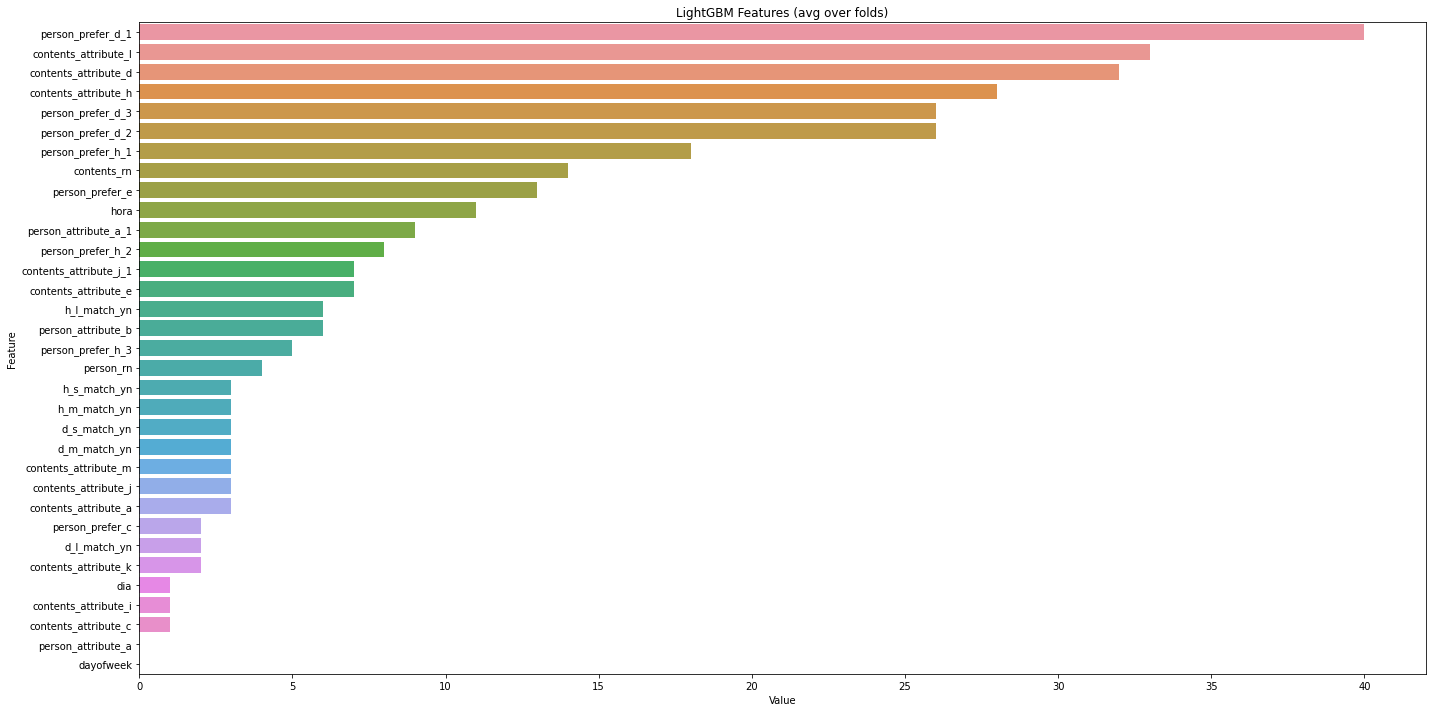

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [21]:
param = study.best_params
param['objective'] = "binary"
param['verbosity'] = 0

In [22]:
#model = lgbm.train(param, cv_data)
model = lgbm.LGBMClassifier(objective="binary", **study.best_params)
model.fit(
    X,
    y
)

LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, feature_fraction=0.2,
               lambda_l1=25, lambda_l2=55, learning_rate=0.8, max_depth=25,
               min_data_in_leaf=400, min_gain_to_split=7.0, n_estimators=1220,
               num_leaves=10, objective='binary')

In [23]:
pred = model.predict(test.drop(['id','contents_open_dt'],axis = 1))
#pred_1 = model.predict_proba(test.drop(['id','contents_open_dt'],axis = 1))

In [24]:
pd.DataFrame(pred).value_counts()

1    24671
0    21733
dtype: int64

In [26]:
sample['target'] = pred
sample.to_csv('/content/drive/MyDrive/Colab Notebooks/dacon_job/sub/job_lgbm.csv',index=False)